In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers
tfgan = tf.contrib.gan
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def show_image(img):
    plt.axis('off')
    plt.imshow(np.squeeze(img.astype(np.uint8)))
    plt.show()
    
def load_image(filepath):
    file = tf.read_file(filepath)
    img_decoded = tf.image.decode_jpeg(file, channels=3)
    return tf.image.resize_images(img_decoded, [64, 64])

summer_filenames = tf.data.Dataset.list_files("../datasets/summer2winter_yosemite/trainA/*.jpg")
summer_images = summer_filenames.map(load_image).batch(10)
summer_iterator = summer_images.make_one_shot_iterator()

winter_filenames = tf.data.Dataset.list_files("../datasets/summer2winter_yosemite/trainB/*.jpg")
winter_images = winter_filenames.map(load_image).batch(10)
winter_iterator = winter_images.make_one_shot_iterator()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    imgs = sess.run(tfgan.eval.image_reshaper(tf.reshape(winter_iterator.get_next(),[10,64,64,3])))
    show_image(imgs)

In [3]:
bn = lambda x: layers.batch_norm(x, scale=True, decay=0.9, epsilon=1e-5, updates_collections=None)
def generator(noise, dim=64):
    net = layers.conv2d(noise, dim, 7, 1, activation_fn=tf.nn.relu, normalizer_fn=bn)
    net = layers.conv2d(net, dim * 2, 3, 2, activation_fn=tf.nn.relu, normalizer_fn=bn)
    net = layers.conv2d(net, dim * 4, 3, 2, activation_fn=tf.nn.relu, normalizer_fn=bn)

    def residual_cell(x, dim):
        y = layers.conv2d(x, dim, 3, 1, activation_fn=tf.nn.relu, normalizer_fn=bn)
        return x + y

    for i in range(9):
        net = residual_cell(net, dim * 4)

    # deconv
    net = layers.conv2d_transpose(net, dim * 2, 3, 2, activation_fn=tf.nn.relu, normalizer_fn=bn)
    net = layers.conv2d_transpose(net, dim, 3, 2, activation_fn=tf.nn.relu, normalizer_fn=bn)
    net = layers.conv2d(net, 3, 7, 1, activation_fn=tf.nn.relu, normalizer_fn=bn)

    return tf.nn.tanh(net)

def discriminator(img, generator_inputs, dim=64):
    net = layers.conv2d(img, dim, 4, 2)
    net = tf.nn.leaky_relu(net, alpha=0.2)

    net = layers.conv2d(net, dim * 2, 4, 2, activation_fn=tf.nn.leaky_relu, normalizer_fn=bn)
    net = layers.conv2d(net, dim * 4, 4, 2, activation_fn=tf.nn.leaky_relu, normalizer_fn=bn)
    net = layers.conv2d(net, dim * 8, 4, 1, activation_fn=tf.nn.leaky_relu, normalizer_fn=bn)
    net = layers.conv2d(net, 1, 4, 8)
    return tf.sigmoid(tf.squeeze(net))

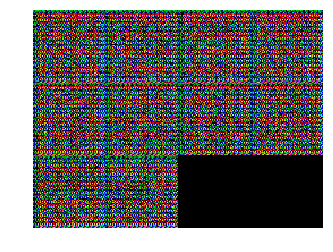

[0.5        0.5        0.5        0.6904636  0.6945047  0.5
 0.5        0.56021655 0.5        0.5608233 ]


In [8]:
# Try out the generator/discriminator
noise_dims = 64
batch_size = 10
noise = tf.random_normal([batch_size, noise_dims, noise_dims, 3])

imgs = generator(noise, noise_dims)
isReal = discriminator(imgs, noise)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    show_image(sess.run(tfgan.eval.image_reshaper(imgs * 255)))
    print(sess.run(isReal))

In [5]:
xs = summer_iterator.get_next()
ys = winter_iterator.get_next()

xs.set_shape([10, 64, 64, 3])
ys.set_shape([10, 64, 64, 3])

cyclegan_model = tfgan.cyclegan_model(generator, discriminator, xs, ys)
tfgan.eval.add_cyclegan_image_summaries(cyclegan_model)

In [6]:
cyclegan_loss = tfgan.cyclegan_loss(cyclegan_model)
gen_opt = tf.train.AdamOptimizer(0.0001)
dis_opt = tf.train.AdamOptimizer(0.0001)
train_ops = tfgan.gan_train_ops(cyclegan_model,
                                cyclegan_loss,
                                gen_opt,
                                dis_opt)
train_steps = tfgan.GANTrainSteps(1, 1)
tfgan.gan_train(train_ops,
                '/tmp/cyclegan/',
                hooks=[tf.train.StopAtStepHook(10)])

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/cyclegan/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/cyclegan/model.ckpt.
INFO:tensorflow:Saving checkpoints for 10 into /tmp/cyclegan/model.ckpt.


10